<a href="https://colab.research.google.com/github/Dharmendra04/Colour-Nerf-/blob/main/Colour_Nerf_Spherical_Harmonics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

In [ ]:
def get_rays(root,mode='train'):
    pose_file_names = os.listdir(root + f'/{mode}/pose')
    intrinsic_file_names = os.listdir(root + f'/{mode}/intrinsics')
    image_file = [f for f in os.listdir(root + '/imgs') if mode in f] 
    
    assert len(pose_file_names) == len(intrinsic_file_names)   #will raise asserition error, if false
    assert len(image_file)==len(pose_file_names)
    
    N = len(pose_file_names)
    poses = np.zeros((N,4,4))
    intrinsics = np.zeros((N,4,4))
    
    image_list = []
    
    for i in range(N):
        #poses
        name = pose_file_names[i]
         
        pose_read = open(root + f'/{mode}/pose/'+ name).read().split()      #split -  coloumns to rows
        poses[i] = np.array(pose_read).reshape(4,4)
        
        #instrinsics
        name = intrinsic_file_names[i]
         
        intrinsics_read = open(root + f'/{mode}/intrinsics/'+ name).read().split()      #split -  coloumns to rows
        intrinsics[i] = np.array(intrinsics_read).reshape(4,4)
        
        #images
        name = image_file[i]
        image_read = imageio.imread(root + '/imgs/'+ name.replace('txt','png'))/255.
        image_list.append(image_read[None,...])     #adding extra dimensions - None
    images = np.concatenate(image_list)
    print(images.shape)
    
    
    h =images.shape[1]
    w = images.shape[2]
    
    
    if images.shape[3] == 4:
        images = images[...,:3]*images[...,-1:]+(1-images[...,-1:])   #color blending 
        
    plt.imshow(images[0])
    plt.show()
    
    print(images.max())
    
    rays_o = np.zeros((N,h*w, 3))
        
    rays_d = np.zeros((N,h*w, 3)) 
    
    target_pixel_values = images.reshape(N,h*w,3)
    print('target',target_pixel_values.shape)

    for i in range(N):
        f = intrinsics[i,0,0]
        c2w = poses[i]

        u = np.arange(w)
        v = np.arange(h)
        u, v = np.meshgrid(u, v)

        dirs = np.stack((u - w / 2,
                         -(v - h / 2),
                         - np.ones_like(u) * f), axis=-1) #transforming image coordiante to camera coordinate

        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1) 

        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
        
        rays_d[i] = dirs.reshape(-1, 3)

        rays_o[i] += c2w[:3, 3]  #adding the intitial x,y,z values from c2w2 (changing from camera coordinate to world coordinate)

       
    
    
    print(rays_o.shape,"o")
    print(rays_d.shape,"d")
        
    return rays_o,rays_d,target_pixel_values

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
 
fox = '/content/drive/MyDrive/nerf/fox/'

#batch_size = 1024
#o_test,d_test,target_pixel_values_test = get_rays('/fox/fox')

Mounted at /content/drive


<ipython-input-2-367e9b414a24>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_read = imageio.imread(root + '/imgs/'+ name.replace('txt','png'))/255.


(90, 400, 400, 4)


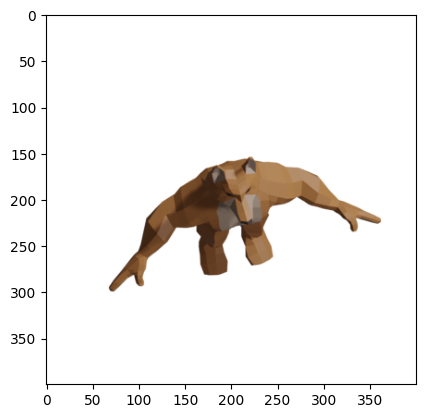

1.0
target (90, 160000, 3)
(90, 160000, 3) o
(90, 160000, 3) d


In [ ]:
o,d,target_pixel_values = get_rays(fox,mode = 'train')

batch_size =1024

In [ ]:
data_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90,400,400,3)[:,100:300,100:300,:].reshape(-1,3).type(torch.float),
                                         torch.from_numpy(d).reshape(90,400,400,3)[:,100:300,100:300,:].reshape(-1,3).type(torch.float),
                                         torch.from_numpy(target_pixel_values).reshape(90,400,400,3)[:,100:300,100:300,:].reshape(-1,3).type(torch.float)),dim=1),batch_size = batch_size,shuffle =True)


data_loader_val = DataLoader(torch.cat((torch.from_numpy(o).reshape(90,400,400,3)[:15,:,:,:].reshape(-1,3).type(torch.float),
                                         torch.from_numpy(d).reshape(90,400,400,3)[:15,:,:,:].reshape(-1,3).type(torch.float),
                                         torch.from_numpy(target_pixel_values).reshape(90,400,400,3)[:15,:,:,:].reshape(-1,3).type(torch.float)),dim=1),batch_size = batch_size,shuffle =True)


data_loader_train = DataLoader(torch.cat((torch.from_numpy(o).reshape(90,400,400,3)[15:,:,:,:].reshape(-1,3).type(torch.float),
                                         torch.from_numpy(d).reshape(90,400,400,3)[15:,:,:,:].reshape(-1,3).type(torch.float),
                                         torch.from_numpy(target_pixel_values).reshape(90,400,400,3)[15:,:,:,:].reshape(-1,3).type(torch.float)),dim=1),batch_size = batch_size,shuffle =True)

## Code Structure

In [ ]:
#positional encoding 
def posenc(x, min_deg, max_deg, legacy_posenc_order=False):
    """Cat x with a positional encoding of x with scales 2^[min_deg, max_deg-1].
    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).
    Args:
      x: jnp.ndarray, variables to be encoded. Note that x should be in [-pi, pi].
      min_deg: int, the minimum (inclusive) degree of the encoding.
      max_deg: int, the maximum (exclusive) degree of the encoding.
      legacy_posenc_order: bool, keep the same ordering as the original tf code.
    Returns:
      encoded: jnp.ndarray, encoded variables.
    """
    if min_deg == max_deg:
        return x
    scales = np.array([2 ** i for i in range(min_deg, max_deg)])
    if legacy_posenc_order:
        xb = x[Ellipsis, None, :] * scales[:, None]
        four_feat = np.reshape(
            np.sin(np.stack([xb, xb + 0.5 * np.pi], -2)), list(x.shape[:-1]) + [-1]
        )
    else:
        xb = np.reshape(
            (x[Ellipsis, None, :] * scales[:, None]), list(x.shape[:-1]) + [-1]
        )
        four_feat = np.sin(np.concatenate([xb, xb + 0.5 * np.pi], axis=-1))
    return np.concatenate([x] + [four_feat], axis=-1)

In [ ]:
#getting the coefficient of spherical harmonic functions
def eval_points_raw(model,points_enc, viewdirs_enc,device='cuda'):
    """
    Evaluate at points, returing rgb and sigma.
    If sh_deg >= 0 / sg_dim > 0 then this will return
    spherical harmonic / spherical gaussians / anisotropic spherical gaussians
    coeffs for RGB. Please see eval_points for alternate
    version which always returns RGB.
    Args:
      points: jnp.ndarray [B, 3]
      viewdirs: jnp.ndarray [B, 3]
      coarse: if true, uses coarse MLP
    Returns:
      raw_rgb: jnp.ndarray [B, 3 * (sh_deg + 1)**2 or 3 or 3 * sg_dim]
      raw_sigma: jnp.ndarray [B, 1]
    """

    points_enc = points_enc.float().to(device)
    viewdirs_enc = viewdirs_enc.float().to(device)

    mlp = model.to(device)

    raw_rgb, raw_sigma = mlp.intersect(points_enc, viewdirs_enc)
    return raw_rgb, raw_sigma

In [ ]:
#getting the final rgb colour from the spherical harmonic coeffcient
def eval_points(eval_points_raw, sh_deg, viewdirs, coarse=False):
    """
    Evaluate at points, converting spherical harmonics rgb to
    rgb via viewdirs if applicable. Exists since jax does not allow
    size to depend on input.
    Args:
      points: jnp.ndarray [B, 3]
      viewdirs: jnp.ndarray [B, 3]
      coarse: if true, uses coarse MLP
    Returns:
      rgb: jnp.ndarray [B, 3]
      sigma: jnp.ndarray [B, 1]
    """
    raw_rgb = eval_points_raw[0]
    raw_sigma = eval_points_raw[1]
    if sh_deg >= 0:
        assert viewdirs is not None
        # (256, 64, 48) (256, 3)
        raw_rgb = eval_sh(sh_deg, raw_rgb.reshape(
            *raw_rgb.shape[:-1],
            -1,
            (sh_deg + 1) ** 2), viewdirs[:, None])
  

    rgb = raw_rgb
    sigma = raw_sigma
    return rgb, sigma

In [ ]:
#getting the ray equation
def create_rays(rays_o,rays_d,tn,tf,num_bins=100,device='cuda'):
            
    t = torch.linspace(tn,tf,num_bins).to(device)  #number of bins
    delta = torch.cat((t[1:]-t[:-1],torch.tensor([1e10],device=device)))
   
    
    #t = [num_bins]             #t = [1,num_bins,1]
    #rays_o, rays_d = [number of rays,3]     rays_o, rays_d = [number of rays,1,3] 
    
   
    x = rays_o.unsqueeze(1) + t.to(torch.float32).unsqueeze(0).unsqueeze(-1) * rays_d.to(torch.float32).unsqueeze(1)  #[num_rays,num_bins,3]

    
    
    return x,delta

#rendering final colour of the points
def rgb_sigma(eval_points,x,num_bins,delta,white_bckgr = True,device='cuda'): 
    color,density = eval_points
    
    #again reshaping to the previosu shape
    
    color = color.reshape((x.shape[1],num_bins,3)).to(device)      #[number of rays,num_bins,3]

    density = density.reshape((x.shape[1],num_bins)).to(device)  #[number of rays,number of bins]


    alpha = 1 - torch.exp(- density * delta.unsqueeze(0))     #[number of rays,num_bins,1]
    weights = transmitance(1-alpha)*alpha       #[num_rays,num_bins]
    
    if white_bckgr:
        c= (weights.unsqueeze(-1)*color).sum(1)   #[num_rays,3]
        weight_sum = weights.sum(-1)      #[num_rays]
        return  c+1-weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1)*color).sum(1)  #[num_rays,3]
        return c

#obtaining transmittance for the rendering function
def transmitance(t1):
    accumulated_transmittance = torch.cumprod(t1, 1)     
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)
   
   

In [ ]:
class nerf(nn.Module):       #nv - number of voxels
    def __init__(self,Lpos = 10,Ldir = 4,hidden_dim=256):
        super(nerf,self). __init__()
        
        self.block1 =nn.Sequential(nn.Linear(21,hidden_dim),nn.ReLU(),     #input 60 posencoding and 3coordinates
                                    nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),    #input hidden neurons 
                                    nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),
                                    nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),
                                    nn.Linear(hidden_dim,hidden_dim),nn.ReLU())         #second value in nn.Linear is number of hidden layers
    
        self.block2 =nn.Sequential(nn.Linear(256+21,hidden_dim),nn.ReLU(),      #skip connection of Lpos*6+3 with feature vector
                                    nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),
                                    nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),
                                    nn.Linear(hidden_dim,hidden_dim+1))                #last neural layer dont have activation function
                                                                                        #+1 is the density, so 257 neuron
            
        self.pred_rgb = nn.Sequential(nn.Linear(21+256,hidden_dim//2),nn.ReLU(),
                                    nn.Linear(hidden_dim//2,16),nn.ReLU())
        
        self.color = nn.Sequential(nn.Linear(16,hidden_dim),nn.ReLU(),
                                  nn.Linear(hidden_dim,3),nn.Sigmoid())
            
         
                                      
    def forward (self,x_enc,x_dir_enc):
        
        h = self.block1(x_enc)    #[batch_size,hidden_dim](feature vector)
        #print(h.shape,'h')
        #print(torch.cat((h,x_enc),dim=1).shape,'cat')
        h = self.block2(torch.cat((h,x_enc),dim=1))  #[batch_size,hideen_dim+1]
        
        #print(h.shape,'hh')
        sigma = h[:,-1]   #assigning the density to sigma
        h = h[:,:-1]     #getting feature vector only without density
        c = self.pred_rgb(torch.cat((h,x_dir_enc),dim=1))   #[batch_size,3]
        #print(c.shape,'cc')

        col = self.color(c)


        
        return torch.relu(col), torch.relu(sigma)
       
    
    def intersect(self,x,d):
        return self.forward(x,d)

## Codes for running the functions 

## Nerf Model

In [ ]:
def training(model,optimizer, scheduler, tn, tf, num_bins, num_epochs, data_loader, device='cuda'):
    training_loss = []
    for epoch in (range(num_epochs)):
        for batch in tqdm(data_loader):
            o_batch = batch[:, :3].to(device)
            d_batch = batch[:, 3:6].to(device)
            
            target = batch[:, 6:].to(device)
            
            x,delta = create_rays(o_batch.to('cuda'),d_batch.to('cuda'),8.,12.,100,device='cuda') #ray equation
            x = x.to('cpu')
            x = x[None]
            #print(x.shape,'x')
            points_enc = posenc(x, 0, 3, legacy_posenc_order=False) #positional encoding for points
            #print(points_enc.shape)

            points_enc = points_enc.reshape(-1,21)
            points_enc =torch.from_numpy(points_enc)

            view_dir_enc = posenc(d_batch.expand(100,x.shape[1],3).transpose(0,1).to('cpu'),0,3,False)  #positional encoding for direction 
            view_dir_enc = torch.from_numpy(view_dir_enc.reshape(-1,21))
            #print(view_dir_enc.shape,'dir')

            eval_points = eval_points_raw(model,points_enc, view_dir_enc,device=device) #obtaining the coefficient and sigma


            prediction = rgb_sigma(eval_points,x,100,delta,white_bckgr = True) #rendering the colour
            

            
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            
        scheduler.step()
        
        
       
        torch.save(model, 'Nerf_model_final')
        
    return training_loss

In [ ]:
device = 'cuda'
tn =8.
tf=12.
model = nerf().to(device)

#hyperparametes
num_epochs = 10
lr =0.001
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
num_bins = 100
gamma =0.5
scheduler =torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10],gamma = gamma)

In [ ]:
training(model,optimizer, scheduler, tn=8., tf=12., num_bins=100, num_epochs = 2, data_loader = data_warmup, device='cuda')
training(model,optimizer, scheduler, tn, tf, num_bins, num_epochs, data_loader_train, device='cuda')

100%|██████████| 11719/11719 [41:07<00:00,  4.75it/s]


[0.019709840416908264,
 0.0177775826305151,
 0.016888711601495743,
 0.013111217878758907,
 0.013785402290523052,
 0.012693440541625023,
 0.012151120230555534,
 0.012492701411247253,
 0.013257494196295738,
 0.011536158621311188,
 0.011528871953487396,
 0.013544538989663124,
 0.016285298392176628,
 0.01282432209700346,
 0.009451786056160927,
 0.012573689222335815,
 0.014593331143260002,
 0.011800859123468399,
 0.011845191940665245,
 0.01207031961530447,
 0.016338100656867027,
 0.010493095964193344,
 0.013189271092414856,
 0.011572537943720818,
 0.01263049803674221,
 0.010433043353259563,
 0.010175193659961224,
 0.01205768994987011,
 0.011430928483605385,
 0.00952197052538395,
 0.013659005984663963,
 0.013375969603657722,
 0.00884196162223816,
 0.009584372863173485,
 0.0066011883318424225,
 0.011259695515036583,
 0.008746692910790443,
 0.009877682663500309,
 0.011951732449233532,
 0.011646483093500137,
 0.009038843214511871,
 0.009952968917787075,
 0.00941559113562107,
 0.0077094002626836

Testing

<ipython-input-2-367e9b414a24>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_read = imageio.imread(root + '/imgs/'+ name.replace('txt','png'))/255.


(10, 400, 400, 4)


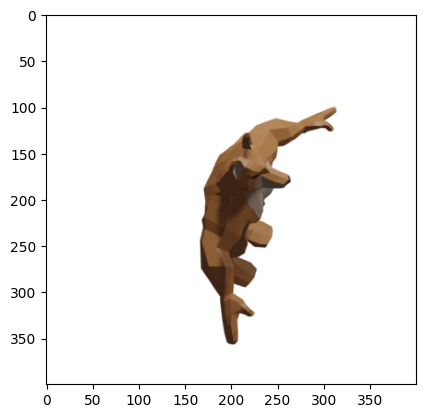

1.0
target (10, 160000, 3)
(10, 160000, 3) o
(10, 160000, 3) d


In [ ]:
batch_size = 1024
o_test,d_test,target_pixel_values_test = get_rays(fox,mode='test')

In [ ]:
model1= torch.load('/content/drive/MyDrive/nerf/plenoctree_final_weight')
model1.eval()

ModuleNotFoundError: ignored

In [ ]:
def msetopsnr(mse):
    return 20*np.log10(1/np.sqrt(mse))
    

@torch.no_grad()
def testing (model,o,d,tn,tf,num_bins =100,chunck_size =10,h=400,w=400, target =None):
    o = o.chunk(chunck_size)
    d = d.chunk(chunck_size)
    
    image = []    #add batch images together to form final image
    
    for o_batch,d_batch in zip(o,d):
        #image_batch = rendering(model,o_batch.to('cuda'),d_batch.to('cuda'),tn,tf ,num_bins=num_bins,device='cuda')
        
        x,delta = create_rays(o_batch.to('cuda'),d_batch.to('cuda'),8.,12.,100,device='cuda') #ray equation
        x = x.to('cpu')
        x = x[None]
        #print(x.shape,'x')
        points_enc = posenc(x, 0, 3, legacy_posenc_order=False) #positional encoding for points
        #print(points_enc.shape)

        points_enc = points_enc.reshape(-1,21)
        points_enc =torch.from_numpy(points_enc)

        view_dir_enc = posenc(d_batch.expand(100,x.shape[1],3).transpose(0,1).to('cpu'),0,3,False)  #positional encoding for direction 
        view_dir_enc = torch.from_numpy(view_dir_enc.reshape(-1,21))
        #print(view_dir_enc.shape,'dir')

        eval_points = eval_points_raw(model,points_enc, view_dir_enc,device=device) #obtaining the coefficient and sigma


        prediction = rgb_sigma(eval_points,x,100,delta,white_bckgr = True) #rendering the colour




        image.append(prediction)
        
    image = torch.cat(image)  #[h*w,3]
    image = image.reshape(h,w,3).cpu().numpy()
    
    if target is not None:
        mse = ((image-target)**2).mean()
    else:
        mse = 0
        
    psnr = msetopsnr(mse)
    
    return image,mse,psnr

In [ ]:
imag, mse, psnr = testing(model1, torch.from_numpy(o[3]).to(device).float(), torch.from_numpy(d[3]).to(device).float(),
                tn, tf, num_bins=100, chunck_size=10, target=target_pixel_values[3].reshape(400, 400, 3))

15.073491201671768


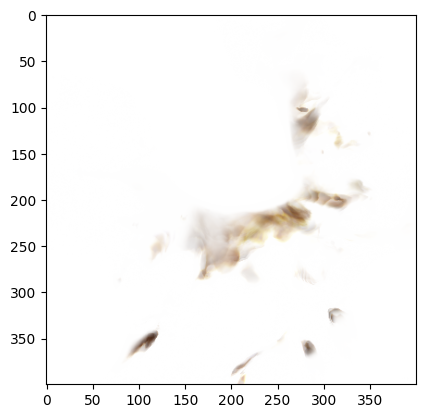

In [ ]:
#our predicted test image
plt.imshow(imag)
print(psnr)

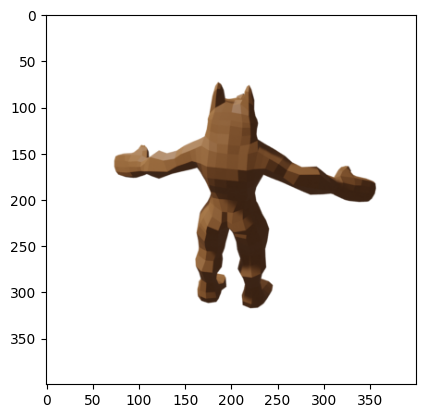

In [ ]:
#ground truth image
plt.imshow(target_pixel_values_test[3].reshape(400,400,3))

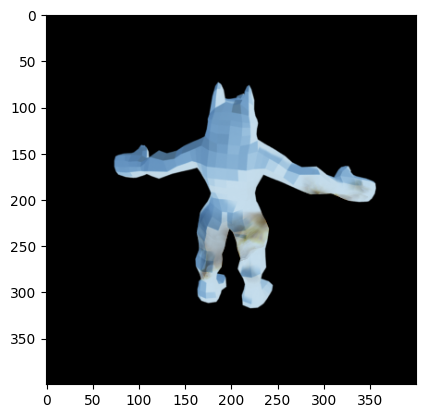

In [ ]:
#difference

plt.imshow(imag - target_pixel_values_test[3].reshape(400,400,3))